Dataset disimpan sebagai dataset_kecelakaan.csv


,kecepatan,jarak,cuaca,risiko_fuzzy
1,112,30,9,86.000000
5,40,33,10,50.000000
6,102,19,8,84.444444
8,94,5,8,84.444444
9,94,29,9,83.252525



Jumlah kasus risiko tinggi (>80): 28
Rata-rata kecepatan: 94.8
Rata-rata jarak: 21.0
Rata-rata cuaca: 6.4


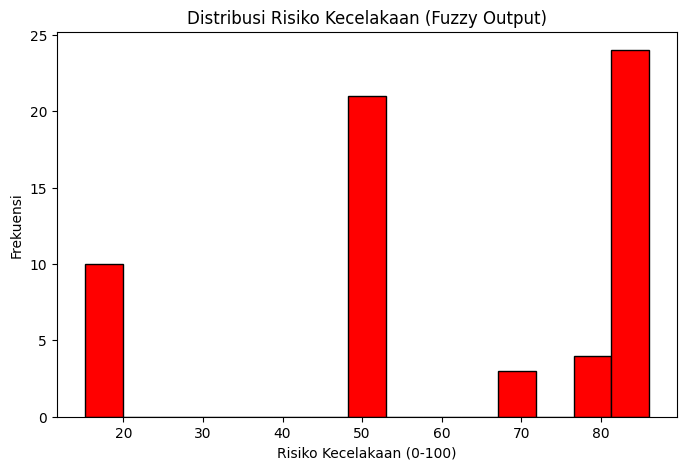

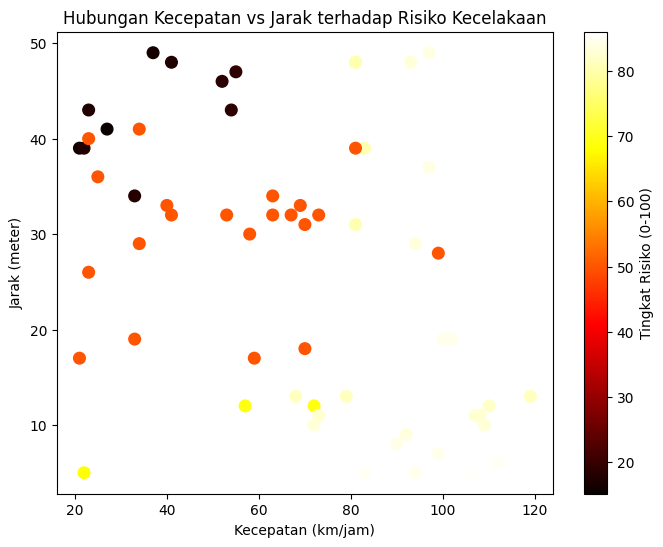


Korelasi antar variabel:
              kecepatan     jarak     cuaca  risiko_fuzzy
kecepatan      1.000000 -0.371771  0.019355      0.777444
jarak         -0.371771  1.000000 -0.003807     -0.565714
cuaca          0.019355 -0.003807  1.000000      0.394823
risiko_fuzzy   0.777444 -0.565714  0.394823      1.000000


In [10]:
# fuzzy_risiko_kecelakaan.ipynb
# Penentuan Risiko Kecelakaan Berkendara dengan Fuzzy Logic (Mamdani)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# 1. Definisi variabel fuzzy
kecepatan = ctrl.Antecedent(np.arange(0, 121, 1), 'kecepatan')   # km/jam
jarak = ctrl.Antecedent(np.arange(0, 51, 1), 'jarak')             # meter
cuaca = ctrl.Antecedent(np.arange(1, 11, 1), 'cuaca')             # skala 1–10
risiko = ctrl.Consequent(np.arange(0, 101, 1), 'risiko')          # output 0–100

# 2. Membership functions
kecepatan['rendah'] = fuzz.trimf(kecepatan.universe, [0, 0, 60])
kecepatan['sedang'] = fuzz.trimf(kecepatan.universe, [40, 70, 100])
kecepatan['tinggi'] = fuzz.trimf(kecepatan.universe, [80, 120, 120])

jarak['dekat'] = fuzz.trimf(jarak.universe, [0, 0, 15])
jarak['sedang'] = fuzz.trimf(jarak.universe, [10, 25, 40])
jarak['jauh'] = fuzz.trimf(jarak.universe, [30, 50, 50])

cuaca['baik'] = fuzz.trimf(cuaca.universe, [1, 1, 5])
cuaca['sedang'] = fuzz.trimf(cuaca.universe, [3, 6, 8])
cuaca['buruk'] = fuzz.trimf(cuaca.universe, [6, 10, 10])

risiko['rendah'] = fuzz.trimf(risiko.universe, [0, 0, 40])
risiko['sedang'] = fuzz.trimf(risiko.universe, [30, 50, 70])
risiko['tinggi'] = fuzz.trimf(risiko.universe, [60, 100, 100])

# 3. Aturan fuzzy
rule1 = ctrl.Rule(kecepatan['rendah'] & jarak['jauh'] & cuaca['baik'], risiko['rendah'])
rule2 = ctrl.Rule(kecepatan['sedang'] & jarak['sedang'] & cuaca['sedang'], risiko['sedang'])
rule3 = ctrl.Rule(kecepatan['tinggi'] & jarak['dekat'], risiko['tinggi'])
rule4 = ctrl.Rule(kecepatan['tinggi'] & cuaca['buruk'], risiko['tinggi'])
rule5 = ctrl.Rule(jarak['dekat'] & cuaca['buruk'], risiko['tinggi'])
rule6 = ctrl.Rule(kecepatan['rendah'] & cuaca['buruk'], risiko['sedang'])
rule7 = ctrl.Rule(kecepatan['sedang'] & jarak['dekat'], risiko['tinggi'])

# 4. Sistem kontrol fuzzy
sistem_risiko_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
sistem_risiko = ctrl.ControlSystemSimulation(sistem_risiko_ctrl)

# 5. Dataset acak
np.random.seed(42)
data = pd.DataFrame({
    'kecepatan': np.random.randint(20, 121, 100),
    'jarak': np.random.randint(5, 51, 100),
    'cuaca': np.random.randint(1, 11, 100)
})

# 6. Hitung output fuzzy untuk tiap baris
hasil = []
for i in range(len(data)):
    sistem_risiko.input['kecepatan'] = data.loc[i, 'kecepatan']
    sistem_risiko.input['jarak'] = data.loc[i, 'jarak']
    sistem_risiko.input['cuaca'] = data.loc[i, 'cuaca']
    sistem_risiko.compute()
    # Check if 'risiko' is in the output before accessing it
    if 'risiko' in sistem_risiko.output:
        hasil.append(sistem_risiko.output['risiko'])
    else:
        # Handle cases where no output is computed (e.g., assign a default value or skip)
        hasil.append(np.nan) # Assign NaN for now

data['risiko_fuzzy'] = hasil
# Drop rows where fuzzy risk could not be computed
data.dropna(subset=['risiko_fuzzy'], inplace=True)
data.to_csv('dataset_kecelakaan.csv', index=False)
print("Dataset disimpan sebagai dataset_kecelakaan.csv")
display(data.head())

# 7. Insight sederhana
insight = data[data['risiko_fuzzy'] > 80]
print(f"\nJumlah kasus risiko tinggi (>80): {len(insight)}")
print("Rata-rata kecepatan:", round(insight['kecepatan'].mean(), 1))
print("Rata-rata jarak:", round(insight['jarak'].mean(), 1))
print("Rata-rata cuaca:", round(insight['cuaca'].mean(), 1))

# 8. Visualisasi distribusi risiko
plt.figure(figsize=(8,5))
plt.hist(data['risiko_fuzzy'], bins=15, color='red', edgecolor='black')
plt.title("Distribusi Risiko Kecelakaan (Fuzzy Output)")
plt.xlabel("Risiko Kecelakaan (0-100)")
plt.ylabel("Frekuensi")
plt.show()

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(data['kecepatan'], data['jarak'],
            c=data['risiko_fuzzy'], cmap='hot', s=70)
plt.colorbar(label='Tingkat Risiko (0-100)')
plt.title("Hubungan Kecepatan vs Jarak terhadap Risiko Kecelakaan")
plt.xlabel("Kecepatan (km/jam)")
plt.ylabel("Jarak (meter)")
plt.show()

# Analisis korelasi
print("\nKorelasi antar variabel:")
print(data.corr(numeric_only=True))